<h2 id="tocheading">Table of Contents</h2>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [14]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from pylab import rcParams
plt.style.use('fivethirtyeight')
%matplotlib inline

#Ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Timeseries

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

#FBprophet

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

# Connect to SQL database
import sqlite3

import itertools

In [15]:
# Import table
connex = sqlite3.connect('bixi_data.db')  
cur = connex.cursor()
df = pd.read_sql_query("SELECT * FROM df_clean", connex)
cur.close()

In [16]:
# Copy of df for TimeSeries because of different manipulation

ts = df.copy(deep = False) # Different manipulation for TimeSeries
ts['date_hour'] = pd.to_datetime(ts['date_hour']) # Converting to datetime type
ts['date_hour'] = ts['date_hour']
ts = ts.set_index('date_hour') # Setting index to Date & Hour 

### Random Forest Regressor - Can also be helpful for selecting X in SARIMAX 

##### Feature engineering

Creating features:
- Extracting hour & month from date to be used as features
- Additional feature for clustering months with similar weather
- Additional feature for hours of the day with similar bike usage due to rush hour

In [17]:
# Extracting hour of the day and month from timestamp to use as features
df.date_hour = pd.to_datetime(df.date_hour)
df['hour'] = df.date_hour.dt.hour
df['month'] = df.date_hour.dt.month
df = df.drop(['date_hour'],axis = 1)

In [18]:
# Creating features to indicate if the month is in a cold or warmer season
df['season'] = df['month']
df['season'] = df['season'].apply(lambda x : 'cold_season' if (x <= 5)|(x >=10) else 'warm_season')

# Creating features to indicate if the hour is considered rush hour or not
df['rush_hour'] = df['hour']
df['rush_hour'] = df['hour'].apply(lambda x : 'rush' if x in [7,8,9,15,16,17,18,19] else 'not_rush')
df.head(2)

,bixi_rentals,day_ind,feels_like,heat_index,precip_hrly,precip_total,humidity,temp,uv_index,wind_speed,condition,is_weekend,is_holiday,hour,month,season,rush_hour
0,50,0.0,27.0,32.0,0.0,0.0,83.0,32.0,0.0,6.0,Fair,0,0,0,4,cold_season,not_rush
1,27,0.0,26.0,34.0,0.0,0.0,75.0,34.0,0.0,10.0,Fair,0,0,1,4,cold_season,not_rush


In [19]:
def create_dummies(col_names, df):
    """
    Function to create dummy variables for all columns mentioned in col_names list for the dataframe df
    
    :param col_names: list of columns to be converted into dummy variables
    :param df: initial dataframe
    
    :returns: dataframe with dummy variables for all columns mentioned in col_names list for the dataframe df
    """
    for col in col_names:
        dummy = pd.get_dummies(df[col], prefix = f'{col}')
        df.drop([col], axis = 1 , inplace = True)
        df = pd.concat([df,dummy] , axis = 1)
    return df

**Dummy variables** for:

- condition: Fair or Windy;
- day_ind: 1 if there is daylight or 0 otherwise;
- month: month of the year, to avoid sense of magnitude, even if month has a logical order;
- hour: hour of the day, to avoid sense of magnitude, even if hour has a logical order;
- is_weekend: 1 is it is the weekend or 0 otherwise;
- is_holiday: 1 is it is the weekend or 0 otherwise;
- season: indicated whether the month is considered to be in the cold season or warmer season
- rush_hour: indicated whether the specified hour is considered rush hour

In [20]:
df = create_dummies(['condition','day_ind','month','hour','is_weekend','is_holiday', 'season','rush_hour'], df)

In [21]:
X_rf = df.drop(['bixi_rentals'], axis = 1)
y_rf = df[['bixi_rentals']].values.ravel()

In [9]:
def grid_search_RFC(X, y, max_depth = [8], max_features = [30], n_estimators = [350]):
    """
    function to grid search random forest regressor and find optimal parameters minimizing MSE
    
    :param X: predictors in dataframe with each predictor as a column
    :param y: array of predicted values
    :param max_depth: list of maximum depth for each tree (see RF regressor parameters)
    :param max_features: list of number of maximum features (see RF regressor parameters)
    :param n_estimators: list of number of trees in forest (see RF regressor parameters)
    
    :returns: optimal parameters for random forest regressor minimizing MSE
    """
    
    param_grid_rf = {'criterion' : ['mse'],  # To minimize variance
                     'max_depth': max_depth,
                     'max_features': max_features ,
                     'n_estimators': n_estimators }  # Number of trees in forest
    
     
    rf = RandomForestRegressor() # Instantiating Random Forest regressor
    grid_rf = GridSearchCV(rf, param_grid = param_grid_rf) # default cv = 3
    grid_rf.fit(X, y)
    
    return grid_rf.best_params_

In [10]:
# Default : max_depth = [5,10,13], max_features = [7,15,18], n_estimators = [100,130,135,175]

In [11]:
grid_search_RFC(X_rf, y_rf, max_depth = [8], max_features = [30], n_estimators = [350])

{'criterion': 'mse', 'max_depth': 8, 'max_features': 30, 'n_estimators': 350}

In [22]:
def fit_predict_RF(X, y, test_size = 1309):
    """
    function to fit and predict a random forest regressor for specified regressors X and
    predicted value y using optimal parameters found with grid search.
    
    :param X: predictors in dataframe with each predictor as a column
    :param y: array of predicted values
    :param test_size: test size, from 0 to 1
    
    :returns: y_train and predicted values, y_test and predicted values
    """

    X = df.drop(['bixi_rentals'], axis = 1)
    y = df[['bixi_rentals']].values.ravel()
    
    train_size = X.shape[0] - test_size
    
    #split our data into a test and train set
    X_train = X[:train_size]
    X_test = X[-test_size:]
    y_train = y[:train_size]
    y_test = y[-test_size:]
    
    best_params = grid_search_RFC(X_train,y_train)

    rf = RandomForestRegressor(criterion = 'mse',
                               max_depth = best_params['max_depth'],
                               max_features = best_params['max_features'],
                               n_estimators = best_params['n_estimators'])
    rf.fit(X_train, y_train)

    y_train_hat = rf.predict(X_train)
    y_test_hat = rf.predict(X_test)
    
    return rf, y_train, y_train_hat, y_test, y_test_hat

In [23]:
def metrics_RF(X,y,test_size = 1309):
    
    rf, y_train, y_train_hat, y_test, y_test_hat = fit_predict_RF(X, y, test_size = test_size)
    
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_hat))
    R2_train = r2_score(y_train, y_train_hat)
    
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_hat))
    R2_test = r2_score(y_test, y_test_hat)
    
    print (f'RMSE_train: {rmse_train}; R2_train : {R2_train}')
    print (f'RMSE_test: {rmse_test}; R2_test : {R2_test}')

In [24]:
rf, y_train, y_train_hat, y_test, y_test_hat = fit_predict_RF(X_rf, y_rf, test_size = 1309)

In [165]:
y_test_hat.shape

(1309,)

In [25]:
metrics_RF(X_rf, y_rf, test_size=1309)

RMSE_train: 232.80255001360123; R2_train : 0.9352170482650859
RMSE_test: 266.4843818264154; R2_test : 0.7986445519725162


In [242]:
def plot_feature_importances(model, X):
    """
    function to plot feature importance
    
    :param model: fitted random forest regressor model
    :param X: dataframe containing regressors
    
    :returns: horizontal barplot of feature importance 
    """
    
    n_features = len(X.columns)
    
    df = pd.DataFrame(data = model.feature_importances_.reshape(1,n_features), columns = X.columns)
    df = df.T
    df = df.sort_values(by =df.columns[0], ascending = False)
    df = df.reset_index()
    
    color = cm.GnBu(np.linspace(0,0.48,n_features), alpha = 0.9)
    
    # Create horizontal barplot 
    plt.figure(figsize=(10,9))
    plt.barh(df['index'], np.sort(model.feature_importances_), align='center', color = color) 
    plt.yticks(np.arange(n_features), df['index'][::-1]) 
    plt.xlabel("Feature importance")
    plt.ylabel("Features")
    plt.title("Feature importance of Random Forest Regressor")
    plt.tight_layout()
    plt.savefig('plots/RF_featimportance.png')
    plt.show()

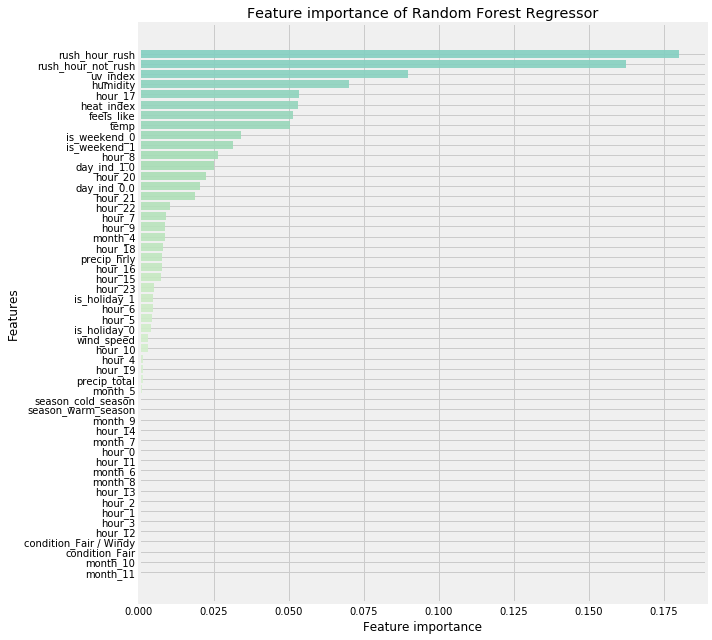

In [243]:
plot_feature_importances(rf,X_rf)

In [46]:
def plot_rf(y_test, y_test_hat, month):
    
    rf_df = pd.DataFrame(data =[y_test, y_test_hat]).T
    rf_df = rf_df.set_index(ts[-1309:].index)
    rf_df.columns = ['Observed', 'Forecast']
    rf_df['error'] = rf_df['Observed'] - rf_df['Forecast']
    ax = rf_df[f'{month}-2018'][:216].plot(linewidth = 1.8, figsize = (19,8))
    ax.set_title('Forecast - Model: Random Forest Regressor', size =20)
    ax.set_ylabel('Number of rentals', size =17)
    ax.set_xlabel('Time', size =17)
    plt.savefig('plots/RF_forecast.png')
    plt.show()

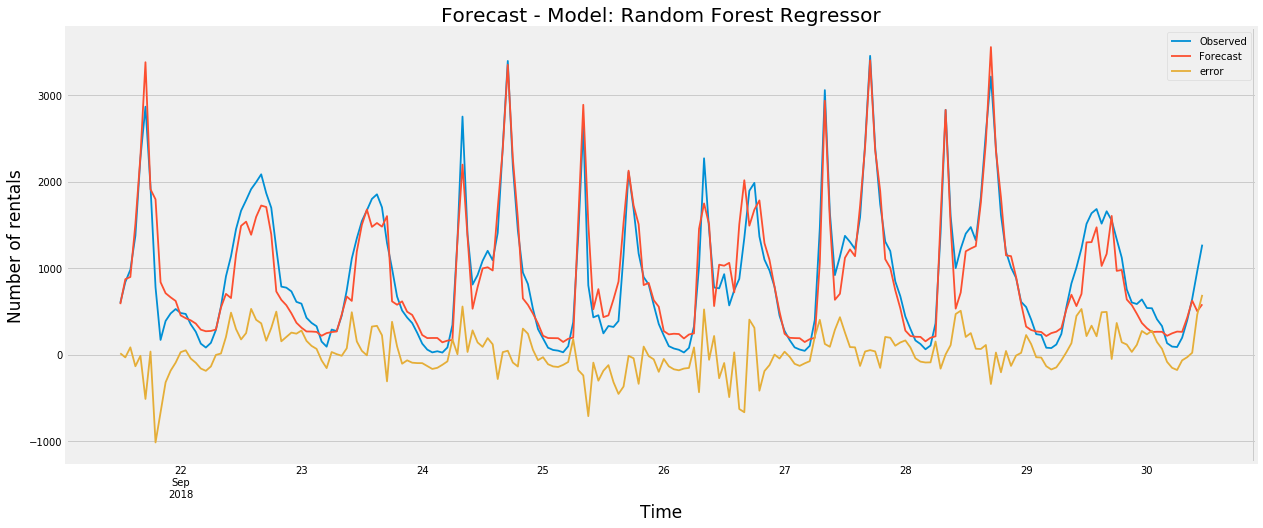

In [47]:
plot_rf(y_test, y_test_hat, '09')

### XGBoost - Boosted trees

In [27]:
# need to specify this to prevent kernel from dying when working with XGboost
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import xgboost as xgb

reg = xgb.XGBRegressor()
param_grid_xg = {'max_depth': [4],
                 'learning_rate' : [0.15],  # After 0.15, performance starts to decrease
                 'gamma' : [3],           # Gamma is for regularizing and avoiding overfitting
                 'n_estimators': [90]}

In [29]:
xg_grid = GridSearchCV(reg, param_grid = param_grid_xg, verbose= 10)
xg_fit = xg_grid.fit(X_rf[:3924], y_rf[:3924])

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] gamma=3, learning_rate=0.15, max_depth=4, n_estimators=90 .......
[CV]  gamma=3, learning_rate=0.15, max_depth=4, n_estimators=90, score=0.6351323324256886, total=   0.7s
[CV] gamma=3, learning_rate=0.15, max_depth=4, n_estimators=90 .......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  gamma=3, learning_rate=0.15, max_depth=4, n_estimators=90, score=0.8457125851170639, total=   0.7s
[CV] gamma=3, learning_rate=0.15, max_depth=4, n_estimators=90 .......


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV]  gamma=3, learning_rate=0.15, max_depth=4, n_estimators=90, score=0.8690695949379899, total=   0.7s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.1s finished


In [30]:
xg_fit.best_params_

{'gamma': 3, 'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 90}

In [31]:
y_train_hat_xg = xg_grid.predict(X_rf[:3924])
y_test_hat_xg = xg_grid.predict(X_rf[-1309:])

In [166]:
y_test_hat_xg.shape

(1309,)

In [33]:
rmse_train_xgb = np.sqrt(mean_squared_error(y_rf[:3924], y_train_hat_xg))
R2_train_xgb = r2_score(y_rf[:3924], y_train_hat_xg)

rmse_test_xgb = np.sqrt(mean_squared_error(y_rf[-1309:], y_test_hat_xg))
R2_test_xgb = r2_score(y_rf[-1309:], y_test_hat_xg)

print (f'RMSE_train: {rmse_train_xgb}; R2_train : {R2_train_xgb}')
print (f'RMSE_test: {rmse_test_xgb}; R2_test : {R2_test_xgb}')

RMSE_train: 211.79209138875382; R2_train : 0.946382724285513
RMSE_test: 228.9684764748469; R2_test : 0.8513478305423114


In [115]:
xgb_df = pd.DataFrame(data= [y_rf[-1309:],y_test_hat_xg]).T
xgb_df = xgb_df.set_index(ts[-1309:].index)
xgb_df.columns = ['Observed', 'Forecast']
xgb_df['error'] = xgb_df['Observed'] - xgb_df['Forecast']

# ax = xgb_df.plot()

In [20]:
xgb_df_imp = pd.read_csv('xgb_results.csv')
xgb_df_imp['date_hour'] = pd.to_datetime(xgb_df_imp['date_hour'])

In [21]:
xgb_df_imp = xgb_df_imp.set_index('date_hour')

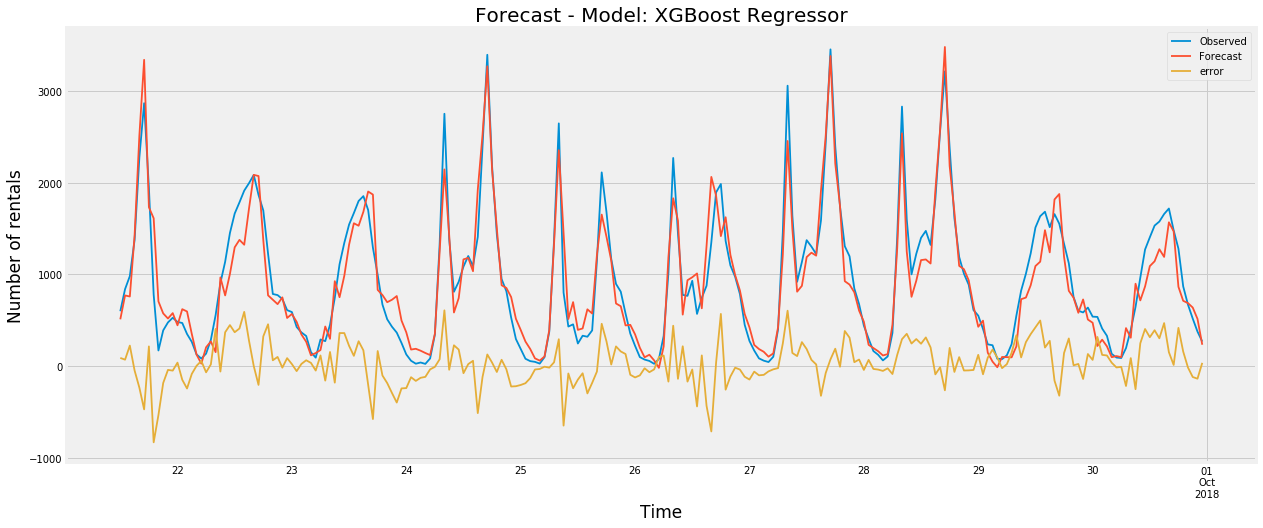

In [24]:
ax = xgb_df_imp['09-2018'].plot(linewidth = 1.8, figsize = (19,8))
ax.set_title('Forecast - Model: XGBoost Regressor', size =20)
ax.set_ylabel('Number of rentals', size =17)
ax.set_xlabel('Time', size =17)
plt.savefig('plots/xgb_forecast.png')
plt.show()

In [118]:
def plot_xgb(y_test, y_test_hat, month):    
    xgb_df = pd.DataFrame(data= [y_rf[-1309:],y_test_hat_xg]).T
    xgb_df = xgb_df.set_index(ts[-1309:].index)
    xgb_df.columns = ['Observed', 'Forecast']
    xgb_df['error'] = xgb_df['Observed'] - xgb_df['Forecast']
    ax = xgb_df[f'{month}-2018'].plot(linewidth = 1.8, figsize = (19,8))
    ax.set_title('Forecast - Model: XGB Regressor', size =20)
    ax.set_ylabel('Number of rentals', size =17)
    ax.set_xlabel('Time', size =17)
    plt.savefig('plots/xgb_forecast.png')
    plt.show()

In [ ]:
# Keeps crashing
# plot_xgb(y_rf, y_test_hat_xg, '09')

### Time Series analysis with SARIMAX(p,d,q)(P,D,Q)m

SARIMAX(p,d,q)(P,D,Q)m has 7 parameters and is used to model a seasonal time series with seasons that repeat at m frequency

- p: Trend autoregressive order i.e. how many previous lags are used for prediction
- d: Trend difference order i.e. how many times the TS was differenced
- q: Trend moving average order
- P: Seasonal parameter for autoregressive order. The hyperparameter m needs to be fixed before setting P,D,Q. For example, if m is set to 24 hours, then setting P = 1 means that the model will offset 24 periods (m*P) to make a prediction.

> $t_1 = t_0 * (m*P)$

- D: Seasonal difference order
- Q: Seasonal moving average order
- m: Number of time steps for a season to repeat

In [34]:
X = ts[['humidity','feels_like','precip_hrly']]
y = ts[['bixi_rentals']]

In [68]:
def stationarity_check(df, window = 24):
    """
    Function to check stationarity of time series by doing the Adfuller test and 
    plotting the rolling mean and rolling standard deviation on the specified window.
    
    :param df: timeseries
    :param window: window for the rolling mean and rolling standard deviation
    """
    rcParams['figure.figsize'] = 18, 8
    rolmean = df.dropna().rolling(window = window).mean()
    rolstd = df.rolling(window = window, center = False).std()
    
    fig = plt.figure(figsize=(18,8))
    orig = plt.plot(df.dropna(), color='teal',label='Original', alpha = 0.55, linewidth=1)
    mean = plt.plot(rolmean, color='yellow', label='Rolling Mean', linewidth=2.0)
    std = plt.plot(rolstd, color='black', label = 'Rolling Std', linewidth =2.0)
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
        
    X = df.dropna().values.flatten()
    result = adfuller(X)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [69]:
def season_decompose_plot(df, freq = 168):
    df.dropna(inplace = True)
    decomp = seasonal_decompose(df.dropna(), model='additive', freq=168)
    ax = decomp.plot()
    plt.show

#### Stationarity check

For the timeseries, the p-value is significantly low and we are over 99% confident that the time series is stationary according to the AD-Fuller test as the ADF statistic is well below the 1% critical value. This tells us that we can forecast using a SARIMAX model.

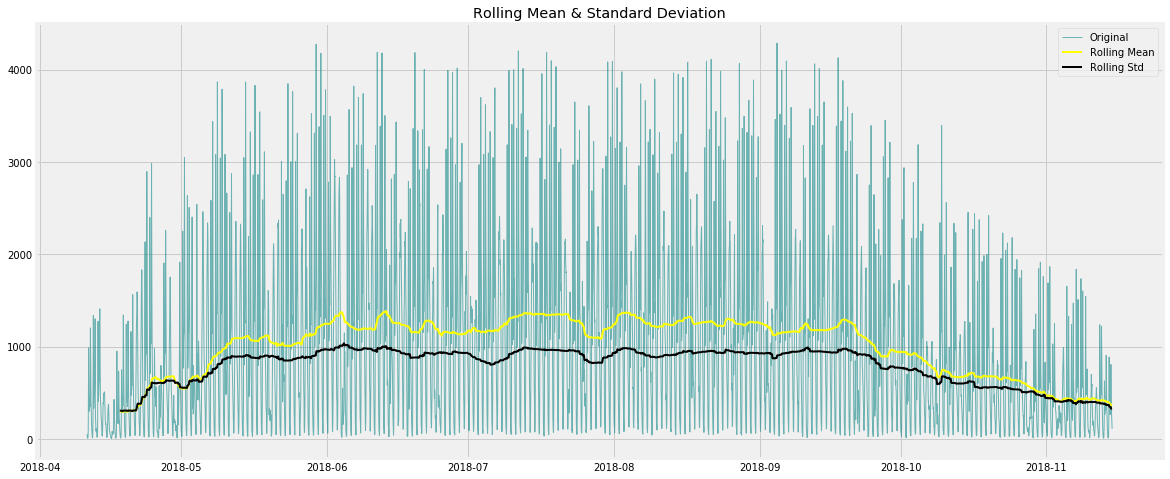

ADF Statistic: -5.604657
p-value: 0.000001
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [119]:
stationarity_check(y, 168)

#### Shifting the distribution

Because bike usage is seasonal, we would expect that bike usage is similar at the same hour of the day during the week days, but we cannot assume that it is true for the weekend. For that reason, using a weekly seasonality would make more sense, as Monday should show a similar usage (assuming everything similar weather) to the previous Monday and the same applies to weekends.

In terms of hours, forecasting using **m = 168** hours is computationally expensive with SARIMAX and would be too time consuming to optimize the model.

For that reason, shifting the distribution of the time series by exactly one week and substracting it by the original time series allows for more opportunity to tune hyperparameters and for the shifted time series, a period of **m = 24** can be used with SARIMAX.

In [35]:
y_shift = y - y.shift(168) # Shifting by a week worth of hours
y_shift.dropna(inplace = True)

#### ADF for shifted time series

The shifted time series is also stationary and the ADF statistic is significantly lower than the 1% critical value. We can reject the null hypothesis that the time series is stationary in favor of the alternative hypothesis. There is no need for differencing to achieve stationarity, therefore **d = 0**.

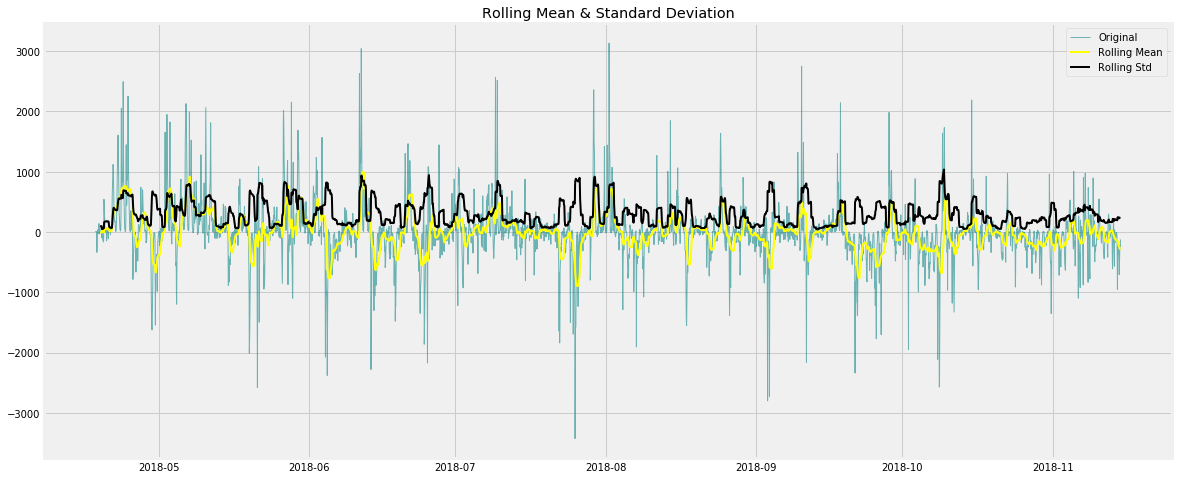

ADF Statistic: -9.144427
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [121]:
stationarity_check(y_shift, 24)

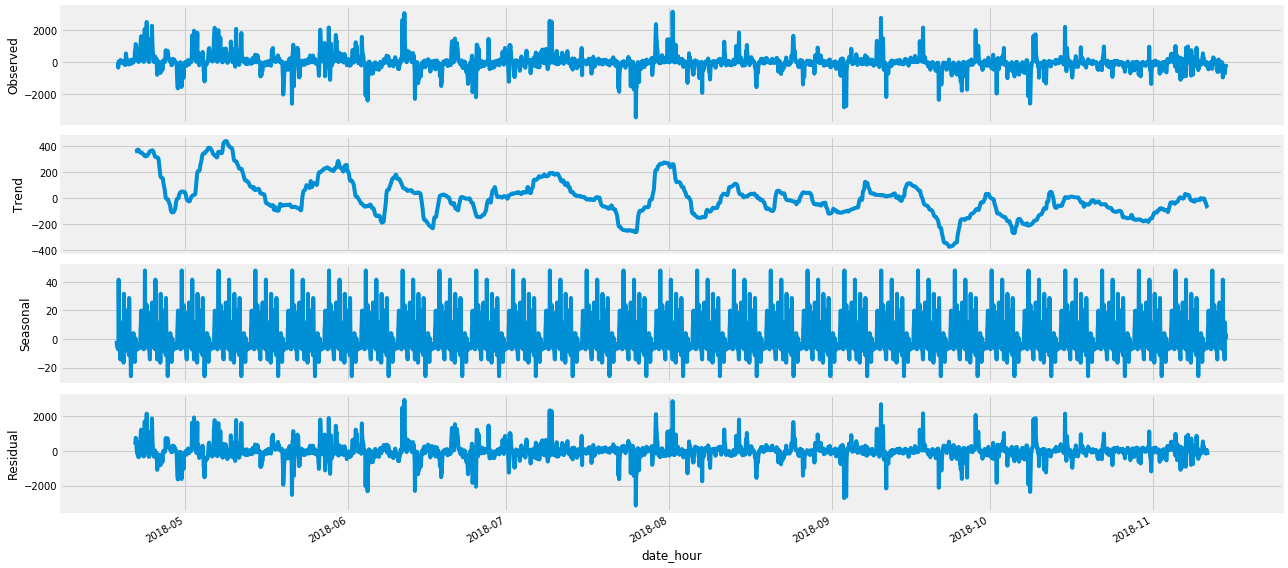

In [124]:
season_decompose_plot(y_shift, freq = 24);

#### ACF & PACF plots

From the plots below, we are able to set initial parameters p, q and P, Q.

- **PACF**: Autoregressive component

There are many instances where the correlation with previous lags is above the confidence band, but the first lag seems to be the most correlated. To avoid complexity, **p = 1** for the AR non-seasonal component. The spike at lag 168 suggests that **P = 1** for the AR seasonal component.


- **ACF**: Moving average

The ACF plot shows that lags 1 and 2 have significant spikes although lags up to 32 are outside of the confidence band. For now, **q = 2** for the non-seasonal AR component. The spike at lag 168 shows that **Q = 1** for the seasonal component of MA.


<function matplotlib.pyplot.show(*args, **kw)>

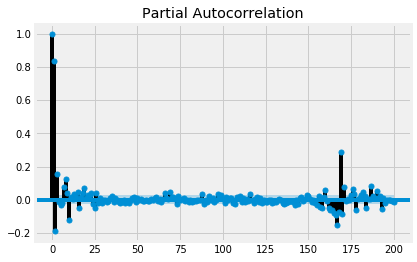

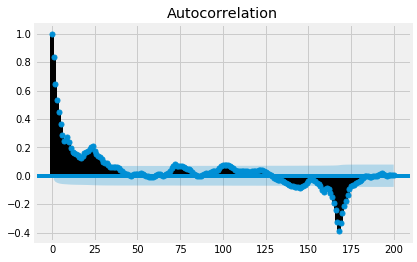

In [239]:
ax = plot_pacf(y_shift,lags = 200, method='ywm')
ax = plot_acf(y_shift, lags = 200)
plt.show

In [36]:
# Test size of 1309 to be consistent with size used in Random Forest regressor (25% of data to test)

X_shift = X[168:] # No need to substract values from one week before for the weather to correspond to rental values
y_train, y_test = y_shift[:3756], y_shift[3756:] # Autoregression
X_train, X_test = X_shift[:3756], X_shift[3756:] # Exogenous variables

#### BaseModel : SARIMAX(1,0,2)(1,0,1)24

In [198]:
base = sm.tsa.statespace.SARIMAX(
    endog = y_train,
    exog = X_train,
    order=(1,0,1),
    seasonal_order=(1,0,1,24),
    enforce_stationarity=True,
    enforce_invertibility=True)

output_base = base.fit(maxiter=300)
output_base.summary()

/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                       bixi_rentals   No. Observations:                 3756
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood              -25955.333
Date:                            Mon, 06 May 2019   AIC                          51926.667
Time:                                    18:37:12   BIC                          51976.516
Sample:                                04-18-2018   HQIC                         51944.393
                                     - 09-21-2018                                         
Covariance Type:                              opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
humidity       -3.0901      0.470     -6.580      0.000      -4.011      -2.170
feels_like      3.3516      0.426      7.874      0.000       2.517       4.186
precip_hrly   -28.7542     15.054     -1.910      0.056     -58.259       0.750
ar.L1           0.7428      0.008     89.143      0.000       0.727       0.759
ma.L1           0.3150      0.014     21.848      0.000       0.287       0.343
ar.S.L24        0.9850      0.008    117.691      0.000       0.969       1.001
ma.S.L24       -0.9999      0.605     -1.654      0.098      -2.185       0.185
sigma2       5.855e+04    3.5e+04      1.672      0.094   -1.01e+04    1.27e+05
===================================================================================
Ljung-Box (Q):                      299.77   Jarque-Bera (JB):             25836.43
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                            -0.07
Prob(H) (two-sided):                  0.75   Kurtosis:                        15.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### GridSearch for optimal SARIMAX parameters

In [38]:
mod = sm.tsa.statespace.SARIMAX(
    endog = y_train,
    exog = X_train,
    order=(1,0,2),
    seasonal_order=(2,0,3,24),
    enforce_stationarity=True,
    enforce_invertibility=True)

output = mod.fit(max_iter = 200)
output.summary()

/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                       bixi_rentals   No. Observations:                 3756
Model:             SARIMAX(1, 0, 2)x(2, 0, 3, 24)   Log Likelihood              -26096.459
Date:                            Wed, 08 May 2019   AIC                          52216.918
Time:                                    13:26:00   BIC                          52291.691
Sample:                                04-18-2018   HQIC                         52243.508
                                     - 09-21-2018                                         
Covariance Type:                              opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
humidity       -4.3268      0.501     -8.639      0.000      -5.308      -3.345
feels_like      5.7809      0.568     10.186      0.000       4.669       6.893
precip_hrly  -425.5591     11.893    -35.783      0.000    -448.868    -402.250
ar.L1           0.8194      0.014     57.286      0.000       0.791       0.847
ma.L1           0.1047      0.017      6.210      0.000       0.072       0.138
ma.L2          -0.1271      0.018     -6.877      0.000      -0.163      -0.091
ar.S.L24       -0.7948      0.035    -22.670      0.000      -0.863      -0.726
ar.S.L48       -0.7276      0.037    -19.920      0.000      -0.799      -0.656
ma.S.L24        0.9042      0.037     24.188      0.000       0.831       0.977
ma.S.L48        0.9143      0.033     27.421      0.000       0.849       0.980
ma.S.L72        0.1918      0.015     12.464      0.000       0.162       0.222
sigma2       6.546e+04    754.544     86.758      0.000     6.4e+04    6.69e+04
===================================================================================
Ljung-Box (Q):                      185.32   Jarque-Bera (JB):             16139.43
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                            -0.04
Prob(H) (two-sided):                  0.53   Kurtosis:                        13.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [391]:
# def grid_search_SARIMAX(endog = y_train, exog = X_train):
    
#     p = [1]
#     d = [0]
#     q = [2] # values to try: list(range(1,3))
#     P = [2] # values to try: list(range(1,4))
#     D = [0]
#     Q = [2,3] # values to try: list(range(1,4))
#     pdq = list(itertools.product(p, d, q))
#     PDQ = list(itertools.product(p, d, q))
#     seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(P, D, Q))]
    
#     gridsearch = {'parameters':[], 'AIC': []}
    
#     for param in pdq:
#         for param_seasonal in seasonal_pdq:
#             gridsearch['parameters'].append(f'{param}x{param_seasonal}')
#             try:
#                 mod = sm.tsa.statespace.SARIMAX(endog= endog,
#                                                 exog= exog,
#                                                 order=param,
#                                                 seasonal_order=param_seasonal,
#                                                 enforce_stationarity=False,
#                                                 enforce_invertibility=False)

#                 results = mod.fit(maxiter = 200)

#                 gridsearch['AIC'].append(results.aic)
#             except:
#                 continue
#     return pd.DataFrame(gridsearch)

In [ ]:
# grid_search_SARIMAX(endog = y_train, exog = X_train)

/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/pacman/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


From the correlogram plot below (bottom right):

- Residuals seem to have low correlation with lagged residuals. There is still some correlation that is not captured by the model and the residuals are not fully random.  

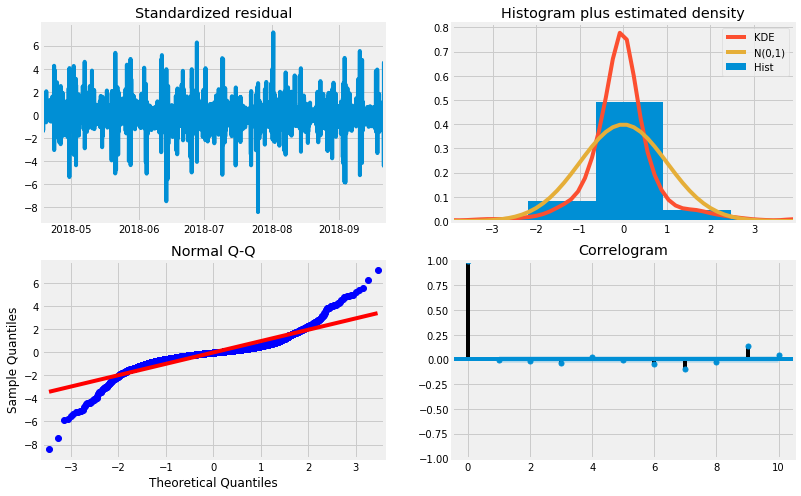

In [23]:
output.plot_diagnostics(figsize=(12, 8));

In [45]:
# Plotting Training predictions 

def plot_training_sarimax(y_shift, X_train, output,month):

    # Predictions for training set

    pred = output.get_prediction(start=0, exogenous=X_train, dynamic=False)
    pred_conf = pred.conf_int()

    rcParams['figure.figsize'] = 20,12
    # Plot observed values

    ax = y_shift[f'{month}-2018'].plot(label='observed', linewidth = 1, c = 'teal')

    #Plot predicted values
    pred.predicted_mean[f'{month}-2018'].plot(ax=ax, label='Forecast', alpha=.9, linewidth = 1, c = 'r')

    # Plot the range for confidence intervals
    ax.fill_between(pred_conf[f'{month}-2018'].index,
                    pred_conf[f'{month}-2018'].iloc[:, 0],
                    pred_conf[f'{month}-2018'].iloc[:, 1], color='orange', alpha=.22)

    #Set axes labels
    ax.set_xlabel('Time', size = 15)
    ax.set_ylabel('1-week difference of Bixi rentals', size = 15)
    ax.set_title('Training Predictions with SARIMAX', size = 20)
    plt.legend()
    plt.show()

In [78]:
y_pred_TS = output.get_prediction(start=0, exogenous=X_train, dynamic=False)
y_pred_confint_TS = y_pred_TS.conf_int()
y_train_hat_TS = y_pred_TS.predicted_mean.values

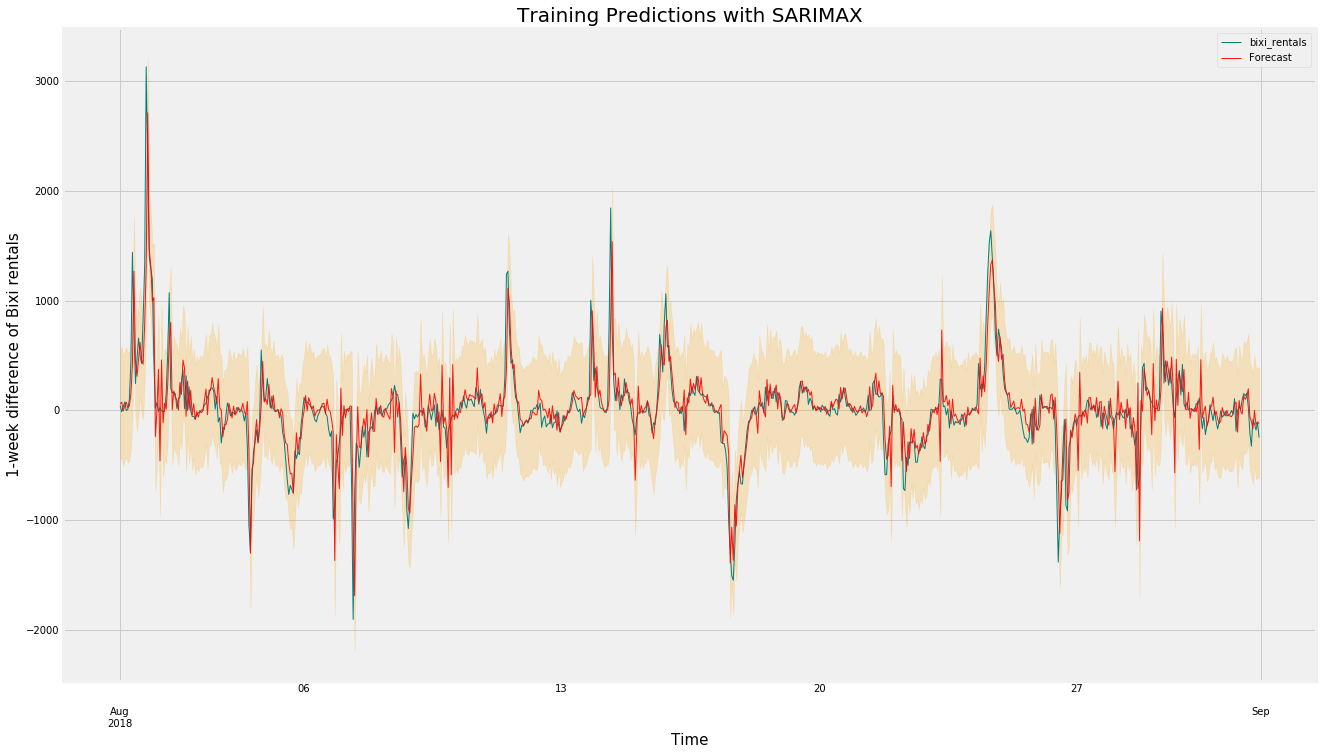

In [25]:
plot_training_sarimax(y_shift, X_train, output)

 The ACF plot of the residuals shows that **not** all autocorrelations are within the threshold limits, indicating that the residuals are not behaving like white noise and there is still autocorellation with previous lags'residuals

#### Forecast with optimal SARIMAX (1, 0, 2)x(2, 0, 3, 24)

##### Training set - Predictions  and Metrics

To get the RMSE score and R2 scores, it makes more sense to compare the observed values to the forecasted rentals. So, we need to add back the shifted distribution we had substracted initially.

In [51]:
# Get the Real and predicted values
pred = output.get_prediction(start=0, exogenous=X_train, dynamic=False)
forecast = pred.predicted_mean.values
real = y_train.values.flatten()

## c is for forecast and d is for observed
c = forecast + y.shift(168).dropna()[:3756].values.flatten()
c = pd.DataFrame(c, columns = ['forecast'], index=y.shift(168).dropna()[:3756].index)
d = y_train.values.flatten() + y.shift(168).dropna()[:3756].values.flatten()
d = pd.DataFrame(d, columns = ['observed'], index=y.shift(168).dropna()[:3756])

# # # RMSE
print('The Root Mean Squared Error of forecast is {}'.format(np.sqrt(mean_squared_error(c,d))))
print('R2 score is {}'.format(r2_score(c,d)))

The Root Mean Squared Error of forecast is 251.75915635775618
R2 score is 0.9271783999962496


##### Testing set - Predictions  and Metrics

In [169]:
fcs = output.get_forecast(steps=1309, exog=X_test, dynamic=False)
fcs_conf = fcs.conf_int()
fcs_conf.head()

,lower bixi_rentals,upper bixi_rentals
2018-09-21 12:00:00,-1527.885866,-524.946872
2018-09-21 13:00:00,-1086.472839,279.113264
2018-09-21 14:00:00,-1065.107905,439.597025
2018-09-21 15:00:00,-1025.804913,565.500046
2018-09-21 16:00:00,-1056.167664,590.730893


In [170]:
a = fcs.predicted_mean.values + y.shift(168)[-1309:].values.flatten()
a = pd.DataFrame(a, index=y[-1309:].index)
b = y_test.values + y.shift(168)[-1309:]
b = pd.DataFrame(b, index=y[-1309:].index)

In [176]:
y_test_hat_TS = a.values.flatten()

In [108]:
# Metrics for testing data
print('The Root Mean Squared Error of forecast is {}'.format(np.sqrt(mean_squared_error(a,b))))
print('R2 score is {}'.format(r2_score(a,b)))

The Root Mean Squared Error of forecast is 372.53262824419653
R2 score is 0.7520641252147787


##### Visualising results

In [106]:
# Plot Forecast with optimal SARIMAX model
def plot_forecast_SARIMAX(fcs, y, y_test):
    
    # Forecast
    a = fcs.predicted_mean.values + y.shift(168)[-1309:].values.flatten()
    a = pd.DataFrame(a, columns = ['Forecast'], index=y[-1309:].index)
    
    # Observed values
    b = y_test.values + y.shift(168)[-1309:]
    b = pd.DataFrame(b, index=y[-1309:].index)
    
    # Error
    error = pd.DataFrame(b.values-a.values, columns = ['error'], index=y[-1309:].index)
    
    #Setting figure size
    rcParams['figure.figsize'] = 19,8
    
    # Plot observed values
    ax = b['09-2018'].plot(label='observed', linewidth = 1, c = 'teal')

    #Plot Forecasted values
    a['09-2018'].plot(ax=ax, label='Forecast', alpha=.9, linewidth = 1, c = 'r')
    
    #Plot error
    error['09-2018'].plot(ax=ax, label='error', alpha=1, linewidth = 1, c = 'orange')
    
    fcs_conf = fcs.conf_int()
    low_ci = pd.DataFrame(fcs_conf.iloc[:, 0])['lower bixi_rentals'].values + y.shift(168)[-1309:].values.flatten()
    low_ci = pd.DataFrame(low_ci, columns = ['lower_bixi_rentals'], index = fcs_conf.iloc[:, 0].index)

    high_ci = pd.DataFrame(fcs_conf.iloc[:, 1])['upper bixi_rentals'].values + y.shift(168)[-1309:].values.flatten()
    high_ci = pd.DataFrame(high_ci, columns = ['upper_bixi_rentals'], index = fcs_conf.iloc[:, 1].index)
    
    # Plot the range for confidence intervals
    ax.fill_between(low_ci['09-2018'].index,
                    low_ci['09-2018'].iloc[:, 0],
                    high_ci['09-2018'].iloc[:, 0], color='blue', alpha=.12)
   
    # Set axes labels
    ax.set_xlabel('Time',size = 17)
    ax.set_ylabel('Forecast - Bixi Rentals',size = 17)
    ax.set_title('Forecast - Model: SARIMAX(1, 0, 2)x(2, 0, 3, 24)', size = 20)
    plt.savefig('plots/Sarimax_forecast.png')
    plt.legend()
    plt.show()

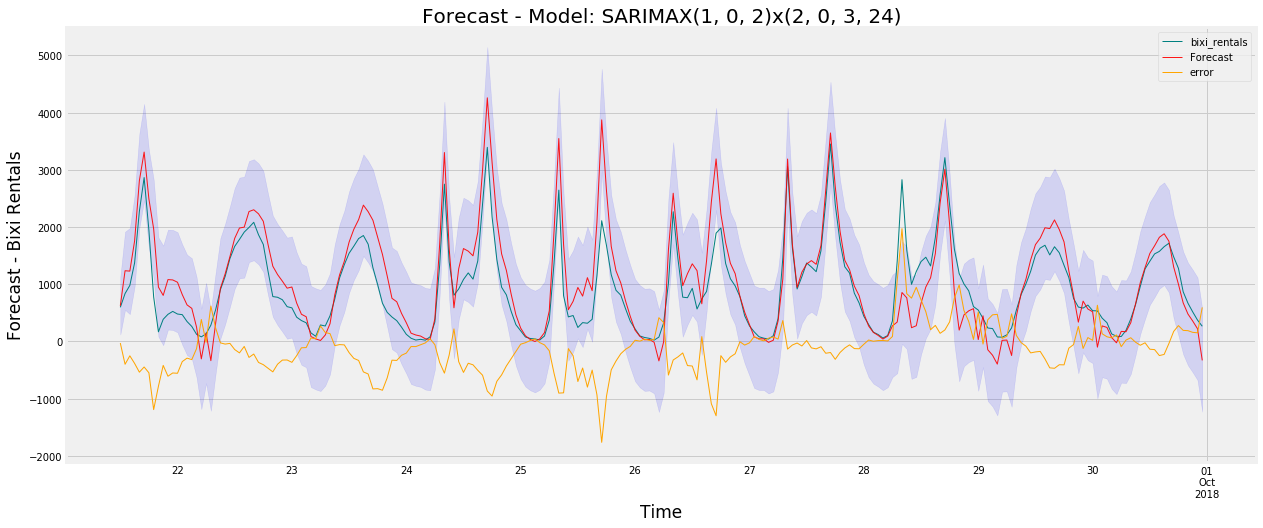

In [107]:
plot_forecast_SARIMAX(fcs, y, y_test)

##### Conclusion for SARIMAX: 

The next step will be to model the timeseries using FBProphet as it allows for more flexibility in modeling and is less time consuming to tune hyperparameters. The optimal model was selected by grid searching different combinations of parameters for p,q,P,Q which minimized the AIC score. 

The Akaike information criterion (AIC) estimates the relative amount of information lost by a given model, the less information a model loses, the higher the quality of that model.

The training set seems to be overfitted and the current model and doesn't generalize too well. There is a significant difference between the R2 score obtained for the training set in comparison to the test set.

More data could be added to increase the training set's size to reduce the RMSE and increase R2.

It will not be optimized further.

### FB Prophet

Contrarly to the SARIMAX model, FBProphet is framed as a "curve-fitting" problem rather than a time-dependency problem. It is an additive regression model.

The model uses time as a regressor instead of the time-dependence of each value within the time-series.

With FB Prophet, it is possible to have multiple seasonalities, for daily and weekly in this case. Each seasonality component is estimated using a tunable parameter for the Fourier order. Increasing the Fourier order allows for additional waves into the model, meaning that the seasonality curve is allowed to change more quickly.

For each timestamp (t), the model predicts a value y(t) represented by the sum of the trend component g(t), the seasonality s(t) component that accounts for periodic changes (daily & weekly for Bixi), a holiday h(t) component plus an error term which is assumed to be normally distributed.

> $y(t) = g(t) + s(t) + h(t) + \epsilon_t$

The model I used includes exogenous variables as well to explain variability.

> $y(t) = g(t) + s(t) + h(t) + \beta * X + \epsilon_t$

In [54]:
ts_fb = y.reset_index().rename(columns = {'date_hour': 'ds', "bixi_rentals": "y"})

In [57]:
ts_fb['heat_index'] = df['heat_index']
# ts_fb['precip_hrly'] = df['precip_hrly']
ts_fb['precip_total'] = df['precip_total']
ts_fb['humidity'] = df['humidity']
ts_fb['wind_speed'] = df['wind_speed']
# ts_fb['holiday'] = df['is_holiday']
ts_fb.tail()

,ds,y,heat_index,precip_total,humidity,wind_speed
5228,2018-11-14 19:00:00,355,17.0,1.0,57.0,9.0
5229,2018-11-14 20:00:00,290,17.0,1.0,55.0,8.0
5230,2018-11-14 21:00:00,236,16.0,1.0,55.0,7.0
5231,2018-11-14 22:00:00,156,16.0,1.0,57.0,6.0
5232,2018-11-14 23:00:00,108,15.0,1.0,63.0,7.0


#### Metrics : RMSE, R2

- **RMSE** will be used as the main metric to choose the best model as it is the most interpretable and can be translated into the average number of bikes the model is off by. It measures the square root of the average sum of squared residuals of the model. 
> RMSE = $\sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_j-\hat{y_j})^{2}}$

- **R2** will be used as a second metric if models show a similar RMSE. R2 measures the variance explained by the model in comparison to the total variance.

In [58]:
def fit_predict(ts_fb,train_obs, daily_seasonality = 25,weekly_seasonality = 170,include_history = False,c = 0.001):
    
    """   
    Takes in dataframe with columns ds, y for target variable, eXogenous variables as first argument (ts_fb)
    and  as second argument (train_obs). Returns model (m) and forecast using 
    the rest of the observations to test.
    
    :param ts_fb: dataframe with columns ds, y containting target variables, eXogenous variables
    :param train_obs: number of training observations
    :param daily_seasonality: order of daily seasonality
    :param weekly_seasonality: order of weekly seasonality
    :param include_history: if set to true, predicts all values; if set to false, trains and test
    :param c: number of training observations
    
    :returns: model and dataframe with forecast using the out of sample observations for testing
    """    
    m = Prophet(growth='logistic',
                yearly_seasonality=False,
                daily_seasonality = daily_seasonality,          
                weekly_seasonality = weekly_seasonality,
                interval_width=0.95,
                changepoint_prior_scale= c)   # change_prior_scale decreased to make the trend less flexible

    m.add_regressor('heat_index')
    m.add_regressor('precip_total')
    m.add_regressor('humidity')
    m.add_regressor('wind_speed')
    m.add_country_holidays(country_name='Canada')
    
    # Setting minimum possible value to 0
    ts_fb['floor'] = 0  
    ts_fb['cap'] = ts_fb.y.max()
    
    # Train model up to train_obs' index
    m.fit(ts_fb[:train_obs])  

    
    future = m.make_future_dataframe(periods=(ts_fb.shape[0] - train_obs),
                                     freq = 'H',
                                     include_history = include_history)
    
    if train_obs <= 1:
        return "train_obs parameter should be above 1, choose an appropriate number of observations for training"
    
    elif include_history == False:
        
        # forecast will return prediction for test set with exogenous variables
        
        # Adding Exogenous variables to future dataframe needed to predict y
        future['heat_index'] = ts_fb.heat_index[train_obs:].reset_index().drop(['index'],axis = 1)
        future['precip_total'] = ts_fb.precip_total[train_obs:].reset_index().drop(['index'],axis = 1)
        future['humidity'] = ts_fb.humidity[train_obs:].reset_index().drop(['index'],axis = 1)
        future['wind_speed'] = ts_fb.wind_speed[train_obs:].reset_index().drop(['index'],axis = 1)
        future['floor'] = 0
        future['cap'] = ts_fb['cap']
        # Test model starting at last observation from train_obs
        forecast = m.predict(future)
    
    else:
        # forecast will return prediction for training set with exogenous variables      
        
        forecast = m.predict(ts_fb[:train_obs])
 
    return m, forecast

In [59]:
def rmse(forecast, ts):
    """
    Function takes in 2 dataframes: forecast from FB Prophet and Timeseries (ts) containing actual values and
    returns DataFrame with actual, real, error values as columns and Root mean square error (RMSE).
    
    :param forecast: dataframe with forecast
    :param ts: dataframe containing actual values
    """

    df = forecast[['ds','yhat']].rename(columns = {'ds': 'date_hour'})
    df['date_hour'] = pd.to_datetime(df['date_hour'])
    df = df.set_index('date_hour')
    
    # Merge on index, by default merge takes inner join
    df = pd.merge(df, ts, left_index=True, right_index=True)[['yhat', 'bixi_rentals']]
    
    # Calculate RMSE
    RMSE = np.sqrt(mean_squared_error(df['yhat'],df['bixi_rentals']))
    
    R2 = r2_score(df['yhat'],df['bixi_rentals'])
    
    results = print(f'RMSE: {RMSE} ; R2: {R2}')
    
    return df, results

The best model so far seems to overfit the training set as it seems to learn the noise rather than the signal.

In [61]:
m_train, forecast_train = fit_predict(ts_fb, train_obs=3924, include_history = True)
rmse(forecast_train,y)[1]

RMSE: 317.9860921087208 ; R2: 0.8622000863339121


In [62]:
m_test, forecast_test = fit_predict(ts_fb, train_obs=3924, include_history = False)
rmse(forecast_test,y)[1]

RMSE: 404.55415032367307 ; R2: 0.7213622495432284


In [68]:
y_train_hat_FB = forecast_train.yhat

In [181]:
y_test_hat_FB = forecast_test.yhat

#### HyperParameter Tuning

- Change_point_prior_scale
- Daily Seasonality Fourier Order
- Weekly Seasonality Fourier Order

In [ ]:
# GridSearch for ChangePoint parameter

def tuning_changepoint_prior_scale(min_c, max_c, step_c, train_obs = 3924):
    """
    Function to GridSearch optimal value of changepoint_prior_scale; increasing it makes the trend more flexible

    :param min_c: minimum change point value to use as starting point
    :param max_c: maximum change point value to use as starting point
    :param step_c: number of change points to try
    :param train_obs: number of training observations
    
    :returns: RMSE and R2 for each value of c
    """
    if train_obs <= 1:
        return "train_obs parameter should be above 1, choose an appropriate number of observations for training"
        
    for c in list(np.linspace(min_c,max_c,step_c)):
        m_test, forecast_test = fit_predict(ts_fb,
                                            train_obs=train_obs,
                                            include_history = False,
                                            c = c)
        print(f'c = {c}')
        rmse(forecast_test,y)[1]
        print(f'\n')

In [80]:
tuning_changepoint_prior_scale(min_c = 0.001, max_c = 1, step_c = 3, train_obs = 3924)

c = 0.001
RMSE: 404.55415032367307 ; R2: 0.7213622495432284


c = 0.5005
RMSE: 476.7774026732931 ; R2: 0.6148130059254501


c = 1.0
RMSE: 480.50999174416415 ; R2: 0.6087345231609886




**Tuning Fourier Order**

- Increasing the Fourier order allows for a less smooth curve fit, meaning that the model is allowed to fit at a higher frequency.

In [53]:
def tuning_daily_seasonality(min_o = 2, max_o = 60, step_o = 8, train_obs = 3924):
    """
    Function to GridSearch optimal Fourier Order of daily seasonality.
    
    :param min_o: minimum order to use as starting point
    :param max_o: maximum order to use as starting point
    :param step_o: number of values to try
    :param train_obs: number of training observations
    
    :returns: RMSE and R2 for each daily seasonality order value
    """
    if train_obs <= 1:
        return "train_obs parameter should be above 1, choose an appropriate number of observations for training"
        
    for order in list(np.linspace(min_o,max_o,step_o)):
        m_test, forecast_test = fit_predict(ts_fb,
                                            daily_seasonality = order,
                                            weekly_seasonality = 170,
                                            train_obs = train_obs,
                                            include_history = False,
                                            c = 0.001)
        print(f'daily seasonality order = {order}')
        rmse(forecast_test, y)[1]
        print(f'\n')

In [68]:
tuning_daily_seasonality(min_o = 23, max_o = 26, step_o = 4, train_obs = 3924)

daily seasonality order = 23.0
RMSE: 406.2646017332993 ; R2: 0.7189047724700608


daily seasonality order = 24.0
RMSE: 405.43157185230694 ; R2: 0.7195879261044946


daily seasonality order = 25.0
RMSE: 404.55415032367307 ; R2: 0.7213622495432284


daily seasonality order = 26.0
RMSE: 405.0349326474538 ; R2: 0.7206765724556531




In [69]:
def tuning_weekly_seasonality(min_o = 10, max_o = 90, step_o = 10, train_obs = 3924):
    """
    Function to GridSearch optimal Fourier Order of weekly seasonality.
    
    :param min_o: minimum order to use as starting point
    :param max_o: maximum order to use
    :param step_o: number of values to try
    :param train_obs: number of training observations
    
    :returns: RMSE and R2 for each daily seasonality order value
    """
    if train_obs <= 1:
        return "train_obs parameter should be above 1, choose an appropriate number of observations for training"
        
    for order in list(np.linspace(min_o,max_o,step_o)):
        m_test, forecast_test = fit_predict(ts_fb.drop(['holiday'],axis =1),
                                            daily_seasonality = 25,
                                            weekly_seasonality = order,
                                            train_obs = train_obs,
                                            include_history = False,
                                            c = 0.001)
        print(f'weekly seasonality order = {order}')
        rmse(forecast_test, y)[1]
        print(f'\n')

In [70]:
tuning_weekly_seasonality(min_o = 150, max_o = 180, step_o = 10, train_obs = 3924)

weekly seasonality order = 150.0
RMSE: 405.92525397166224 ; R2: 0.7181097966352991


weekly seasonality order = 153.33333333333334
RMSE: 408.1009269818328 ; R2: 0.7160112512533678


weekly seasonality order = 156.66666666666666
RMSE: 405.93137714001597 ; R2: 0.7185634925974702


weekly seasonality order = 160.0
RMSE: 409.19228348445927 ; R2: 0.7160032729457475


weekly seasonality order = 163.33333333333334
RMSE: 408.7370984658919 ; R2: 0.7165496530944009


weekly seasonality order = 166.66666666666666
RMSE: 408.62180643070053 ; R2: 0.7154418539190919


weekly seasonality order = 170.0
RMSE: 404.55415032367307 ; R2: 0.7213622495432284


weekly seasonality order = 173.33333333333334
RMSE: 405.03784008309475 ; R2: 0.7207337095872263


weekly seasonality order = 176.66666666666666
RMSE: 403.6554875854622 ; R2: 0.7223812656194013


weekly seasonality order = 180.0
RMSE: 407.27978773427685 ; R2: 0.7165639787875063




##### Visualizing results

In [270]:
def plot_results_fb(ts_fb, forecast_test, size = 1309, month = '10'):
    
    df = ts_fb[-size:]
    df = df[['ds','y']].reset_index().drop(['index'],axis = 1)
    df['yhat'] = forecast_test['yhat']
    df['yhat_lower'] = forecast_test['yhat_lower']
    df['yhat_upper'] = forecast_test['yhat_upper']
    df['error'] = (df['yhat'] - df['y'])
    df = df[:168]
    
    # Plot a sample of one week
    ax = df.set_index('ds')[['y','yhat','error']].plot(linewidth = 1.8, figsize = (19,8)) 
    ax.fill_between(df.set_index('ds').index,df.yhat_lower,df.yhat_upper, color='blue', alpha=.12)

    ax.set_title('Forecast - Model: FBProphet with Daily & Weekly seasonality', size =20)
    ax.set_ylabel('Number of rentals', size =17)
    ax.set_xlabel('Time', size =17)
    plt.savefig('plots/fb_forecast.png')
    plt.show()
    

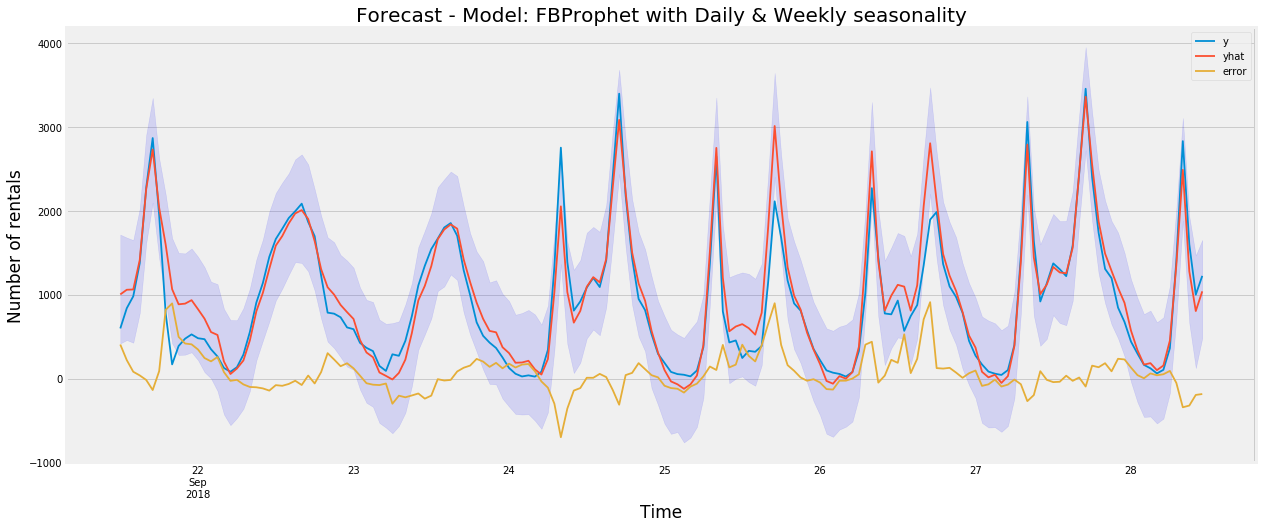

In [272]:
plot_results_fb(ts_fb, forecast_test, size = 1309, month = '10')

### Model Stacking

To stack the 4 models, fitting a linear regression to predict training actual rentals with the model predictions for the training set as predictors will give us different coefficients to use in a weighted average to stack the models.

1. Fit a linear regression on the training actual values

In [77]:
y_train_hat_TS

In [82]:
X_preds = pd.DataFrame(data = [y_train_hat[168:],y_train_hat_xg[168:],y_train_hat_TS, y_train_hat_FB[168:]]).T
X_preds.columns = ['Random_Forest_Regressor','XGBoost_Regressor','SARIMAX(1,0,2)(2,0,3)24','FP_prophet']

In [90]:
X_preds.head()

,Random_Forest_Regressor,XGBoost_Regressor,"SARIMAX(1,0,2)(2,0,3)24",FP_prophet
0,162.054712,20.769573,-243.470764,-482.287874
1,129.448730,-41.246620,-59.197110,-685.300026
2,129.420240,-146.990524,-494.381603,-772.792043
3,129.826987,-95.311226,378.561372,-669.838265
4,107.147046,-71.159645,-156.384068,-717.702008


In [93]:
from sklearn.linear_model  import LinearRegression

In [144]:
reg = LinearRegression(normalize=True).fit(X_preds,ts['bixi_rentals'][168:3924])

In [153]:
weights = reg.coef_

In [154]:
print(f'RandomForestRegressor: {weights[0]}\nXGBoost: {weights[1]}\nSARIMAX: {weights[2]}\nFB_Prophet: {weights[3]}')

RandomForestRegressor: 0.2955404138782251
XGBoost: 0.6192844978845874
SARIMAX: 0.08572847844921101
FB_Prophet: 0.12688710988303


Train - Stacked

In [159]:
y_final_preds = weights[0]*X_preds.iloc[:,0] + weights[1]*X_preds.iloc[:,1]+weights[2]*X_preds.iloc[:,2]+weights[3]*X_preds.iloc[:,3]

In [160]:
np.sqrt(mean_squared_error(y_final,ts['bixi_rentals'][168:3924]))

209.47700771594825

In [161]:
r2_score(y_final,ts['bixi_rentals'][168:3924])

0.9449797468528242

2. Forecast using stacked model on the test set

In [163]:
test_set = ts['bixi_rentals'][-1309:]

In [182]:
X_preds_test = pd.DataFrame(data = [y_test_hat,y_test_hat_xg,y_test_hat_TS, y_test_hat_FB]).T
X_preds_test.columns = ['Random_Forest_Regressor','XGBoost_Regressor','SARIMAX(1,0,2)(2,0,3)24','FP_prophet']

In [184]:
y_final_preds_test = weights[0]*X_preds_test.iloc[:,0] + weights[1]*X_preds_test.iloc[:,1]+weights[2]*X_preds_test.iloc[:,2]+weights[3]*X_preds_test.iloc[:,3]

In [185]:
np.sqrt(mean_squared_error(y_final_preds_test,test_set))

251.3329945447773

In [186]:
r2_score(y_final_preds_test,test_set)

0.8589717223585884

In [190]:
y_final_preds_test.shape

(1309,)

In [191]:
test_set.shape

(1309,)

In [196]:
final_residuals = y_final_preds_test.values - test_set.values

(array([  1.,   1.,   1.,   5.,  13.,  48., 180., 424., 286., 140.,  72.,
         56.,  31.,  29.,  11.,   7.,   2.,   1.,   0.,   1.]),
 array([-862.10586496, -746.92538434, -631.74490373, -516.56442311,
        -401.3839425 , -286.20346188, -171.02298126,  -55.84250065,
          59.33797997,  174.51846058,  289.6989412 ,  404.87942181,
         520.05990243,  635.24038304,  750.42086366,  865.60134428,
         980.78182489, 1095.96230551, 1211.14278612, 1326.32326674,
        1441.50374735]),
 <a list of 20 Patch objects>)

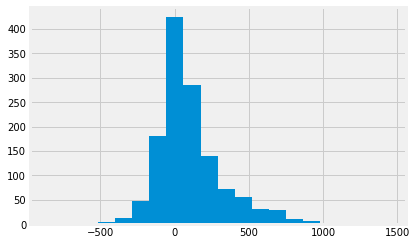

In [202]:
plt.hist(x = final_residuals, bins = 20)

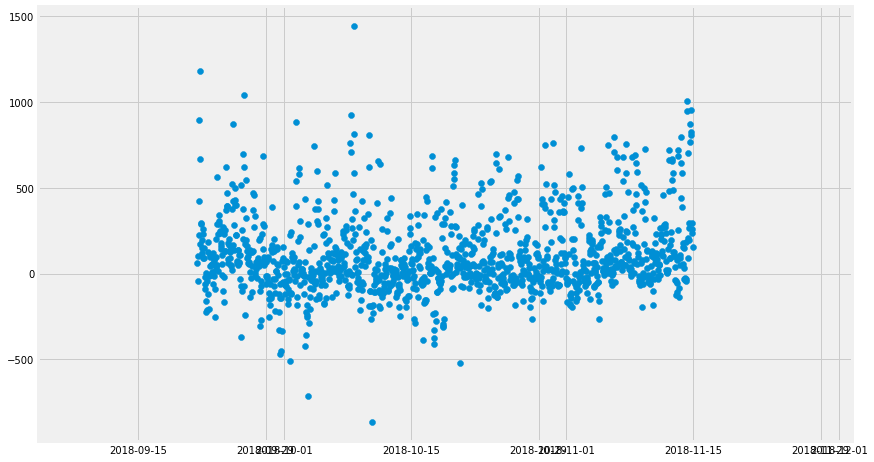

In [210]:
plt.figure(figsize= (13,8))
ax_final = plt.scatter(x=test_set.index, y = final_residuals)



## Algo options

#### Deep Learning - LSTM - because of weather or event in the city that will hike up the demand